# Project 2: The Effect of Angular Perturbation and Electron Count on Circular Orbital Stability for Radially Symmetric Degenerate Electrons

## Introduction

**Research Question:** *How do perturbations to initial turning angle and electron count affect orbital stability for a system of radially-symmetric degenerate electrons?*

The purpose of this project is to explore the orbital stability for a neutral-charge systems of many electrons and one nucleus as a function of very slight perturbations to the angular direction on a single electron in the system. The orbital stability of the system is defined as the average absolute standard deviation of the orbital distance of all electrons in the system over an angular period of the incidence electron (that being, in the time that it takes the perturbed electron to reach the same angle with respect to the nucleus, how much does the radial displacement from the nucleus deviate, on average, for each electron in the system). More stable systems will minimize this average deviation, and the value can be defined loosely from there.

The Bohr model predicts a saturnian orbit with an orbital radius at the Bohr radius $a_0$ for every orbit where the number of electrons is equal to the number of protons [1](https://people.isy.liu.se/jalar/kurser/QF/references/Bohr1913I.pdf). For this simulation, I'm interested in using a uniform orbital geometry (that being, $n=3$ produces a triangular configuration of electrons, $n=4$ produces a square configuration, $n=5$ produces a pentagon, $n=6$ is a hexagon, etc.) and then observing the long-term orbital stability of the simulation (across all electrons in the system, so a singular electron or two being ejected may still be considered more stable than other systems if this ejection keeps the rest of the system stable, although this is an unlikely situation) as measured by the variance in the normalized radial distance (by the Bohr radius).

To do this, for every number of electrons $n$, I'll equally radially space the electrons around the nucleus (which will have a charge and mass equal to $n$ protons such that the overall atom is completely neutral), and for every simulation, perturbation will only occur on the singular electron placed at the angle $\theta=0$ to the nucleus (or $(a_0,0)$ in cartesian coordinates).

### Assumptions:

I made the following assumptions in this system:

1. A "stable" orbit is defined as a circular (uniform radial distance) orbit that remains at the Bohr radius $a_0$. This is a valid assumption as the number of protons is equal to the number of electrons for each simulation, so as predicted by the Bohr model, an ideal, stable orbit should remain at the Bohr radius (implying it is completely uniform). 
2. All electrons are at the **same** energy level (so this simulation deviates from the Bohr model as all of these electrons are degenerate), so they can all remain at the same orbital distance. This question allows us to further verify the results of our model as electron orbits are quantized by energy level, so a true stable orbit can only occur when the additional electrons are "knocked" into place: i.e., we can theoretically predict that without providing any angular perturbation whatsoever, simulations that occur at ground-state energy levels ($n=1$ and $n=2$) should remain stable, then simulations at the immediate next energy level should be of similar stability levels ($n=3,4$), and then configurations at higher energy levels should become increasingly more unstable due to all electrons existing at the same energy.

**Code Block Summary:** Imports

In [1]:
from numpy.testing import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.integrate import solve_ivp

In addition to the standard libraries of `numpy`, `matplotlib`, and `scipy`, this project also makes use of `dataclasses` [2](https://docs.python.org/3/library/dataclasses.html) for data structures then `io` [3](https://docs.python.org/3/library/io.html) and `Pillow` [4](https://pypi.org/project/pillow/) for storing images in variables.

In [2]:
from dataclasses import dataclass
from PIL import Image
import io

**Code Block Summary:** Constants

In [3]:
NUM_PERIODS=10

# orbital radius of all of the electrons
bohr_radius = 5.29e-11

# electron mass
m = 9.1e-31

# coulomb's constant
k = 9e9

# charge of an electron
q = 1.6e-19

## Helper Functions

**Code Block Summary:** This function saves graphs to memory to be stored into variables, and from there, I can called them again using `display`. This workflow makes managing the Jupyter notebook easy, and it also allows me to define all of my graphs together but display them in separate cells.

In [4]:
def save_graph_and_close():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    graph = Image.open(buf)
    plt.close()
    return graph

**Code Block Summary:** Vector Rotation

Counterclockwise rotation of a vector $\mathbf{v}$ by angle $\theta$ is just multiplication by the rotation matrix $\mathbf{R}(\theta)$

$$R(\mathbf{v},\theta) = \mathbf{R}(\theta) \mathbf{v} = \begin{pmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{pmatrix} \mathbf{v}.$$

In [5]:
def rotate_vector_2d(vec, theta):
    """
    Rotates vector `vec` counterclockwise by `theta` radians
    """
    rotation_matrix = \
        np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    rotation_matrix[np.abs(rotation_matrix) < 1e-15] = 0
    return rotation_matrix @ vec

**Code Block Summary:** These are some functions for applying vector operations along lists of vectors, like getting the unit vector (or direction) of a vector and getting the unit vector of each vector in a list.

For `unit_vector`: unit vectors can always be calculated as
$$\hat{v} = \frac{\mathbf{v}}{|\mathbf{v}|}$$
(for simplicity, I may also write $|\mathbf{v}|$ as $v$).

In [6]:
def unit_vector(v):
    """
    Returns the associated unit
    """
    return np.array(v) / np.linalg.norm(v)

def magnitudes(vector_list):
    return np.array([np.linalg.norm(vec) for vec in vector_list])

def unit_vectors(s):
    return np.array([unit_vector(v) for v in s])

**Code Block Summary:** This is a function for converting a list of cartesian coordinates (i.e., a cartesian trajectory) into a list of polar coordinates (i.e., a polar trajectory). Cartesian trajectories are passed in with as a pair $$\langle \mathbf{x}(t), \mathbf{y}(t) \rangle = \langle (x_1, x_2, x_3, \dots, x_n), (y_1, y_2, y_3, \dots, y_n ) \rangle,$$ and from there, these coordinate lists can be easily converted into polar coordinates as $$r = \sqrt{x^2 + y^2}$$ and $$\theta = \tan^{-1}(y/x),$$ producing list $$\langle \mathbf{r}, \mathbf{\theta} \rangle = \langle (r_1, r_2, r_3, \dots, r_n), (\theta_1, \theta_2, \theta_3, \dots, \theta_n) \rangle.$$

In [7]:
def cartesian_to_polar(coords):
    """
    Convert an array of 2D Cartesian coordinates 
    to polar coordinates. Coordinates must be of 
    shape (2,n).
    """
    coords = np.asarray(coords)

    if coords.ndim == 2 and coords.shape[0] == 2:
        x = coords[0]
        y = coords[1]
        r = np.sqrt(x**2 + y**2)
        theta = np.unwrap(np.arctan2(y, x))
        
        return np.array([r, theta])

    else:
        raise ValueError(f"Expected shape (2,n), got {coords.shape}")

**Code Block Summary:** These blocks are code for simplifying the state system of `solve_ivp` for my Electron usecase. `ElectronState` defines the most basic state information for an individual electron in a state vector.

In [8]:
@dataclass
class ElectronState:
    pos: np.array = None
    vel: np.array = None

`interpret_state` unpacks a one-electron state vector from $[x, y, v_x, v_y]$ into separate vectors $\mathbf{r}=\langle x, y\rangle$ and $\mathbf{v}=\langle v_x, v_y \rangle$.

In [9]:
def interpret_state(state):
    """
    Unpacks a one-electron state vector
    into an ElectronState.
    """
    pos = np.array(state[0:2])
    vel = np.array(state[2:4])
        
    return ElectronState(pos, vel)

`set_state_index` essentially does the opposite and packs a state vector with position and velocity components into a multi-electron state vector.

In [10]:
def set_state_index(state, i, pos, vel):
    base = 4 * i
    state[base : base + 4] = [pos[0], pos[1], vel[0], vel[1]]

`get_state` is a selector for a multi-electron state vector to get a singular electron state.

In [11]:
def get_state(state, i):
    """
    Slices an n-electron state 
    vector on electron index i
    """
    return state[4*i : 4*i + 4]

`get_electron` is a composition of `get_state` and `interpret_state` to automatically select and unpack the electron state at electron index $i$ in a multi-electron state vector.

In [12]:
def get_electron(state, i):
    return interpret_state(get_state(state, i))

**Code Block Summary:** This is the function for calculating the coulomb force between two objects, A and B. The distance vector should be $\mathbf{d} = \mathbf{r}_A - \mathbf{r}_B,$ i.e., the displacement vector between the two of them. The calculation then made is
$$\mathbf{F} = \frac{kq^2}{|\mathbf{d}|^3} \mathbf{d}$$
if this is a force between two electrons only and
$$\mathbf{F} = -N\frac{kq^2}{|\mathbf{d}|^3} \mathbf{d}$$
if this is between an electron and the nucleus, where $N$ is the number of protons in the nucleus.

In [13]:
def calculate_coulomb_force(distance_vec, attract=False, num_protons=1):
    mag = k * q ** 2 / np.linalg.norm(distance_vec) ** 3 * distance_vec
        
    # reverse direction if it's attractive
    if attract:
        return num_protons * mag * -1
    else:
        return mag

**Code Block Summary:** This is a more involved test to ensure that the coulomb force calculation is completely correct. The first test is the trivial ($N=1$) electron-proton case. The second test is an electron-electron calculation from $(r_0,0)$ to $(0,r_0)$. For an electron at $(r_0,0)$ and $(0,r_0)$ (or $(r_0,0)$ and $(r_0, \pi/2)$), $\mathbf{r} = \langle r_0, -r_0 \rangle$, making $\hat{r} = 1/\sqrt{2}(i - j)$
$$\mathbf{F} = \frac{kq^2}{r^2} \hat{r} = \frac{kq^2}{2r_0^2} \frac{r_0}{\sqrt{2}}(\hat{i} - \hat{j}) = \frac{kq^2}{2^{3/2} r_0^2} (\hat{i} - \hat{j})$$

**Code Block Summary:** This block calculates the necessary starting values (radial distance, initial tangential velocity, and the period). The idea for this simulation is that the simulation begins at its most stable uniform-orbit configuration for each $N$, and these calculations are made with that in mind, so these values don't depend on the initial incidence angle.

*Derivation:* Knowing that the number of electrons $N$ is equal to the number of protons $Z$. The radial distance is $r = \frac{N^2}{Z^2} a_0 = a_0$, the nuclear attraction is
$$\mathbf{F}_{nuc} = -Z \frac{kq^2}{r^2}.$$
Using the incidence electron $\theta=0$ as our basepoint (which is okay as all of the electrons will have the same tangential velocity in the end), the coordinates of the incidence electron would be $(r,0)$ (both cartesian and polar) and $(r\cos\theta_j,r\sin\theta_j)$ for the other electron in cartesian coordinates. 

As $\theta = \frac{2\pi}{N}j$, this makes the displacement vector between them (pointing toward the incidence electron)
$$\mathbf{d}_j=(r,0)-\left(r\cos\theta_j,r\sin\theta_j\right)=r \left\langle 1-\cos\theta_j, -\sin\theta_j \right\rangle.$$
Then, easily, we can calculate the coulombic force as
$$\mathbf{F}_j = \frac{kq^2}{|\mathbf{d}_j|^3} \mathbf{d}_j,$$
and the total repulsive force would therefore be 
$$\mathbf{F}_{rep} = \sum_{j=1}^{N-1} \mathbf{F}_j,$$
which makes the net force
$$\mathbf{F}_{net} = \mathbf{F}_{nuc} + \mathbf{F}_{rep}$$
Then, acceleration is $a=F/m$ and the speed is $v=\sqrt{ar}$. The velocity must be tangential to the circle, so $\theta_v=\theta_j+\pi/2$ and $T=\frac{2\pi r}{v}$.

In [14]:
def calculate_starting_values(num_electrons):
    """
    Calculates the necessary tangential velocity 
    and radial distance to have the most stable 
    uniform circular orbit for a given starting
    number of electrons N.
    
    Estimates the period as well based off of
    this, without consideration of the incidence
    angle theta.
    """
    radius = bohr_radius
    
    # nuclear attractive force
    f_nuc  = np.array([-num_electrons * k * q ** 2 / radius ** 2, 0])
    theta  = np.linspace(0, 2 * np.pi, num_electrons, endpoint=False)[1:]
    
    # repulsive force from other electrons
    f_rep = np.zeros(2)
    
    # (implicitly zero if no other electrons are in system, i.e., n=1)
    if num_electrons > 1:
        dist   = radius * np.array([ 1 - np.cos(theta), -np.sin(theta) ])
        forces = k * q ** 2 * dist / np.linalg.norm(dist,axis=0)
        f_rep  = np.sum(forces, axis=1)
    
    f_net = f_nuc + f_rep    
    accel = f_net / m
    
    speed  = np.sqrt(np.linalg.norm(accel) * radius)
    period = 2 * np.pi * radius / speed
    
    return radius, speed, period

**Code Block Summary:** This function generates the initial state given the number of electrons $N$ and the incidence angle $\theta$. Essentially, what it does is it produces the initial state vector for each electron, equally angularly spaced along the circular orbit curve of the nucleus.  

In [15]:
def generate_initial_state(num_electrons, incidence_angle=None):
    """
    Produces the initial state to match the number 
    of electrons and the incidence angle
    """
    angles = np.linspace(0, 2 * np.pi, num_electrons, endpoint=False)
    radius, velocity, period = calculate_starting_values(num_electrons)
    
    if num_electrons <= 0:
        raise ValueError('num_electrons must be a natural number')
    
    # radially place each electron based on starting values
    state = np.zeros(4 * num_electrons)
    for i, theta in enumerate(angles):
        pos = radius * np.array([ np.cos(theta), np.sin(theta)])
        vel = velocity * np.array([-np.sin(theta), np.cos(theta)])
        set_state_index(state, i, pos, vel)
    
    # apply an incidence angle to the interest electron 
    # (always at theta=0) if the user supplied one
    if incidence_angle is not None:
        vel = np.array(state[2:4])
        rotated = rotate_vector_2d(vel, incidence_angle)
        state[2] = rotated[0]
        state[3] = rotated[1]
        
    return state, period

**Code Block Summary:** This function calculates the orbital stability score of an orbit path as measured by the multiplicative inverse of variance in $r/a_0$ -- assuming that a stable orbit would be circular. This value is designed to prefer orbits that are as uniform and *circular* as possible, and although there can be stable orbits with elliptical or otherwise noncircular orbits, this is a valid assumption as the starting geometry for the simulation theoretically produces circular orbits for unperturbed systems (i.e. $\theta=0$ should be circular). This is more of an *instability* score, as more stable, circular orbits have this value approach 0.

In [16]:
def calculate_orbital_stability(time, polar_trajectory):
    radial  = polar_trajectory[0]
    angular = polar_trajectory[1]
    
    return np.var(radial / bohr_radius)

## Core Simulation

**Code Block Summary:** This is the function to calculate the trajectory of all of the electrons in the system by solving the differential equations.

In [17]:
@dataclass
class ElectronData:
    pos:            np.array = None
    radial_pos:     np.array = None
    vel:            np.array = None
    
    kinetic_energy:   np.array = None
    potential_energy: np.array = None
    momentum:         np.array = None

@dataclass
class CalculationResult:
    time:            np.array   = None
    electrons:       list       = None
    stability_score: np.float64 = -1
    
    total_kinetic_energy:    np.array = None
    total_potential_energy:  np.array = None
    total_mechanical_energy: np.array = None
    total_momentum:          np.array = None

def calculate(n, angle, num_periods=NUM_PERIODS, rtol=1e-9, atol=1e-9):
    state0, period = generate_initial_state(n, angle)
    t_span = (0, num_periods * period)

    def diff_eqns(t, state):
        # state is a flat 1D array of length 4*n
        state_delta = np.zeros_like(state)

        for i in range(n):
            electron = get_electron(state, i)

            # attractive net force contribution from the nucleus
            net_force = calculate_coulomb_force(electron.pos, attract=True, num_protons=n)

            # repulsive net force contribution from the other electrons
            for j in range(n):
                if i == j:
                    continue

                other = get_electron(state, j)
                net_force += calculate_coulomb_force(electron.pos - other.pos)

            accel = net_force / m
            set_state_index(state_delta, i, electron.vel, accel)

        return state_delta


    calculation = solve_ivp(diff_eqns, t_span, state0, rtol=rtol, atol=atol)
    
    
    results = CalculationResult()
    results.time = np.array(calculation.t)
    results.electrons = []
    
    for i in range(n):
        electron = get_electron(calculation.y, i)
        pos = electron.pos
        vel = electron.vel
        radial_pos = cartesian_to_polar(pos)
        
        kinetic_energy = (1/2) * m * magnitudes(vel.transpose()) ** 2
        momentum       = m * magnitudes(vel)
        
        # potential energy has to be calculated via re-simulation
        potential_energy = np.zeros_like(results.time)

        for t_idx in range(len(results.time)):
            r_i = pos[:, t_idx]
            U_nuc = -n * k * q**2 / np.linalg.norm(r_i)

            U_rep = 0
            for j in range(n):
                if i == j:
                    continue
                other = get_electron(calculation.y, j)
                r_j = other.pos[:, t_idx]
                U_rep += k * q**2 / np.linalg.norm(r_i - r_j)

            # 1/2 to avoid double-counting
            potential_energy[t_idx] = U_nuc + 0.5 * U_rep

        results.electrons.append(ElectronData(pos, radial_pos, vel, \
                                              kinetic_energy, potential_energy, momentum))
    
    # store all of the post-calculations
    results.stability_score      = np.mean([calculate_orbital_stability(results.time, electron.radial_pos) \
                                            for electron in results.electrons])
    results.total_kinetic_energy = np.sum([electron.kinetic_energy \
                                           for electron in results.electrons], axis=0)
    results.total_potential_energy  = np.sum([electron.potential_energy \
                                              for electron in results.electrons], axis=0)
    results.total_mechanical_energy = results.total_kinetic_energy + results.total_potential_energy
    
    results.total_momentum = np.sum([electron.momentum for electron in results.electrons], axis=0)
    
    return results

### Mini-Test of the Trivial Case with One Electron and No Perturbation Angle

**Code Block Summary:** This code tests the barebones calculations performed under `calculate` for the trivial case $n=1$. This makes for a good test, as we know that this should be an automatically stable orbit with the simplest conditions under the Bohr model.

In [18]:
def test_calculation_raw():
    trivial_state, period = generate_initial_state(1, 0)
    
    def diff_eqns(t, state):
        state_delta = np.zeros_like(state)
        electron = get_electron(state, 0)
        net_force = calculate_coulomb_force(electron.pos, attract=True)
        
        accel = net_force / m
        set_state_index(state_delta, 0, electron.vel, accel)

        return state_delta
    
    calculation = solve_ivp(diff_eqns, (0, period), trivial_state, rtol=1e-9, atol=1e-9)
    electron = get_electron(calculation.y, 0)
    radial_pos = cartesian_to_polar(electron.pos)
    results = dict()
    
    # Cartesian trajectory
    plt.figure(figsize=(6,6))
    plt.plot(electron.pos[0], electron.pos[1])
    plt.plot(0, 0, 'ro', label='Nucleus')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(f'Cartesian Trajectory of the Affected Electron')
    plt.legend()
    plt.grid(True)
    results['cartes'] = save_graph_and_close()
    
    # Polar trajectory
    plt.figure()
    plt.plot(radial_pos[1], radial_pos[0])
    plt.xlabel('θ (rad)')
    plt.ylabel('Radial Distance from Nucleus (m)')
    plt.title(f'Radial Trajectory of 10 orbits for the Affected Electron')
    plt.grid(True)
    results['polar'] = save_graph_and_close()
    
    # Speed vs. Time graph
    plt.figure()
    speed = magnitudes(electron.vel.transpose())
    plt.plot(calculation.t, speed)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Speed vs. Time')
    plt.grid(True)
    results['speed'] = save_graph_and_close()
    
    return results
    
trivial_test = test_calculation_raw()

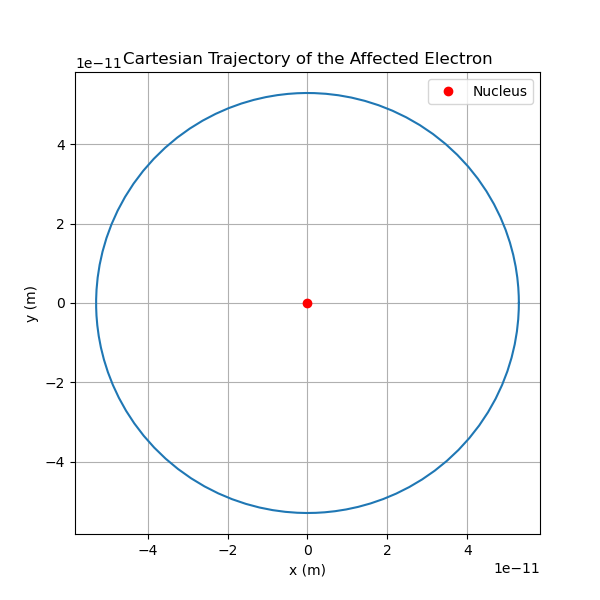

In [19]:
display(trivial_test['cartes'])

**Figure 1.** Visual observation confirms that the basic differential equations being used are conceptually correct and numerically stable for the trivial case, and this is best confirmed by simply understanding that the cartesian trajectory should be a perfectly uniform circle.

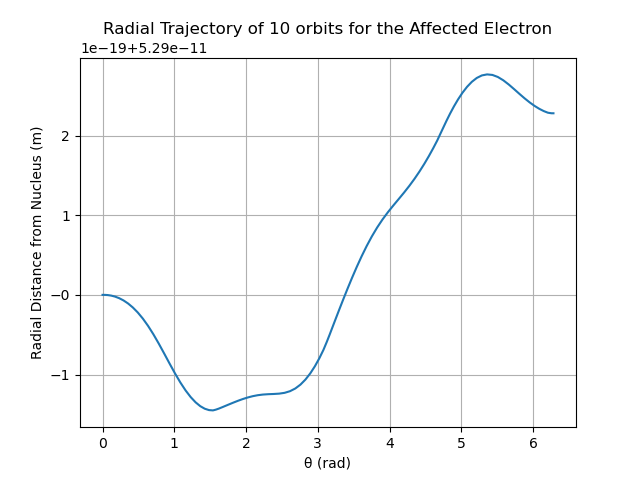

In [20]:
display(trivial_test['polar'])

**Figure 2.** The radial trajectory also confirms our claim. The variance of the graph is extremely small in comparison to $a_0$ (about $-2$ to $3\times 10^{-19}$ against $5.3 \times 10^{-11}$), so all of these values can be said to be roughly $a_0$. The minor variance seen is so small that it is likely the result of the discrete time evolution of this simulation.

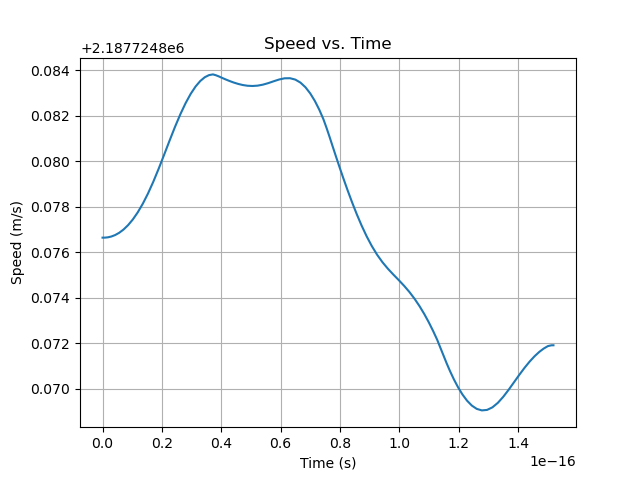

In [21]:
display(trivial_test['speed'])

**Figure 3.** Furthermore, the speed vs. time graph further confirms our suspicions. We see another near-zero variation relative to $a_0$ in the graph here as well, even in the trivial case, as this speed should be constant. Otherwise, however, as each of these values are roughly near each other, we can further state that the differential equations used are correct up to the fundamental limitations of using discrete time evolution.

## Performing a Full, Detailed Simulation

**Code Block Summary:** This block visualizes a singular simulation, so it not only performs the necessary calculations but also provides some considerably more detailed plots, and this can aid in testing the full functionality of the `calculate` function for much higher $n$.

In [22]:
@dataclass
class Visualizations:
    all_electrons_one_period: Image = None
    
    all_electrons:        Image = None
    radial_trajectory:    Image = None
    cartesian_trajectory: Image = None
    energy:               Image = None
    multipanel:           Image = None
    calc:                 CalculationResult = None
    
def simulate(n, angle, plot=False):
    sim = calculate(n, angle)
    affected_electron = sim.electrons[0]
    
    figures = Visualizations()
    figures.calc = sim
    
    # Radial distance vs. Angle
    plt.figure()
    plt.plot(affected_electron.radial_pos[1], affected_electron.radial_pos[0])
    plt.xlabel('θ (rad)')
    plt.ylabel('Radial Distance from Nucleus (m)')
    plt.title(f'Radial Trajectory of the Affected Electron')
    plt.grid(True)
    figures.radial_trajectory = save_graph_and_close()
    
    # determine the scales
    plt.figure(figsize=(6,6))
    
    # We want to show the full trajectory of this electron, 
    # but we want the x and y scales to match (in order to 
    # avoid producing a distortion/warping).
    x_min, x_max = np.min(affected_electron.pos[0]), np.max(affected_electron.pos[0])
    y_min, y_max = np.min(affected_electron.pos[1]), np.max(affected_electron.pos[1])
    x_span = x_max - x_min
    y_span = y_max - y_min
    span = max(x_span, y_span)
    
    x_mid = 0.5 * (x_min + x_max)
    y_mid = 0.5 * (y_min + y_max)

    plt.xlim(x_mid - span/2, x_mid + span/2)
    plt.ylim(y_mid - span/2, y_mid + span/2)
    
    # Cartesian Trajectory
    plt.plot(affected_electron.pos[0], affected_electron.pos[1], label='Trajectory')
    plt.plot(0, 0, 'ro', label='Nucleus')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(f'Cartesian Trajectory of the Affected Electron')
    plt.legend()
    plt.grid(True)
    figures.cartesian_trajectory = save_graph_and_close()
    
    # All Electrons
    plt.figure(figsize=(6,6))
    for electron_index, electron in enumerate(sim.electrons):
        plt.plot(electron.pos[0], electron.pos[1], 
                 label=f'Electron {electron_index+1}')
        
    plt.plot(0, 0, 'ro', label='Nucleus')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(f'Cartesian Trajectory of all Electrons')
    plt.legend(loc='upper right')
    plt.grid(True)
    figures.all_electrons = save_graph_and_close()
    
    # All Electrons (One Period)
    plt.figure(figsize=(6,6))
    angles = affected_electron.radial_pos[1] % (2 * np.pi)
    period_indices = np.where(angles[1:] < angles[:-1])[0] + 1
    one_period = period_indices[0] if period_indices.size > 0 else None
    
    for electron_index, electron in enumerate(sim.electrons):
        plt.plot(electron.pos[0,0:one_period], 
                 electron.pos[1,0:one_period], 
                 label=f'Electron {electron_index+1}')
        
    plt.plot(0, 0, 'ro', label='Nucleus')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(f'Cartesian Trajectory of all Electrons for One Period')
    plt.legend(loc='upper right')
    plt.grid(True)
    figures.all_electrons_one_period = save_graph_and_close()

    # Speed vs. Time
    plt.figure()
    speed = magnitudes(affected_electron.vel.transpose())
    plt.plot(sim.time, speed)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Speed vs. Time')
    plt.grid(True)
    figures.speed_graph = save_graph_and_close()
    
    # Energy Plot
    plt.figure()
    plt.plot(sim.time, affected_electron.kinetic_energy, label="Kinetic Energy")
    plt.plot(sim.time, sim.total_kinetic_energy,         label='Total Kinetic Energy')
    plt.plot(sim.time, sim.total_potential_energy,       label='Total Potential Energy')
    plt.plot(sim.time, sim.total_mechanical_energy,      label='Total Mechanical Energy')
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (J)")
    plt.title("Energy vs Time")
    plt.legend()
    plt.grid(True)
    figures.energy = save_graph_and_close()
    
    """
    Multipanel Plot of Radial Distance, Speed, and Energy Against Time
    (Note: These would absolutely be handled better with individual plots,
           but if the graders wish for a multipanel plot, then their wish
           is my humble command.)
    """
    fig, axs = plt.subplots(3,1, sharex=True, figsize=(8,8))
    fig.subplots_adjust(hspace=0)
    
    # Radial Distance
    axs[0].set_title('Normalized Radial Distance, Speed,\nand Energy vs. Time')
    axs[0].plot(sim.time, affected_electron.radial_pos[0] / bohr_radius)
    axs[0].set_ylabel('Normalized Radial\nDistance ($m/a_0$)')
    
    axs[1].plot(sim.time, speed)
    axs[1].set_ylabel('Speed (m/s)')
    
    axs[2].plot(sim.time, affected_electron.kinetic_energy, label="Kinetic Energy")
    axs[2].plot(sim.time, sim.total_kinetic_energy,         label='Total Kinetic Energy')
    axs[2].plot(sim.time, sim.total_potential_energy,       label='Total Potential Energy')
    axs[2].plot(sim.time, sim.total_mechanical_energy,      label='Total Mechanical Energy')
    axs[2].set_ylabel('Energy (J)')
    axs[2].set_xlabel('Time')
    axs[2].legend()
    
    figures.multipanel = save_graph_and_close()
    
    return figures

### Visual Test of 5 Electrons with a Perturbation Angle

**Code Block Summary:** Now, we can perform a visual test of $n=5$ with an incidence angle of $\theta=-10^{-14}$ rad. It's a very small incidence angle, so this should be a roughly stable orbit, for some period of time before eventually breaking orbit. The purpose of this experiment is to visually see the mechanics of this system in action, and in doing so, we can see how the system's stability evolves with time.

In [23]:
test = simulate(n=5, angle=-1e-14)

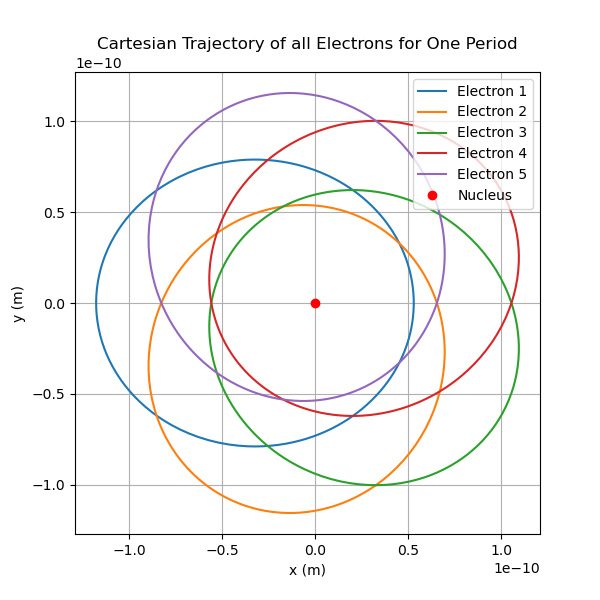

In [24]:
display(test.all_electrons_one_period)

**Figure 4.** For a 5-electron system, we get a plot of the electrons motion that is distinctly reminiscent of the Rutherfordian nuclear model, which is a natural extension of the Saturnian model. As can be seen, the first period of orbit is completely periodic, with all electrons beginning and ending in the same place.

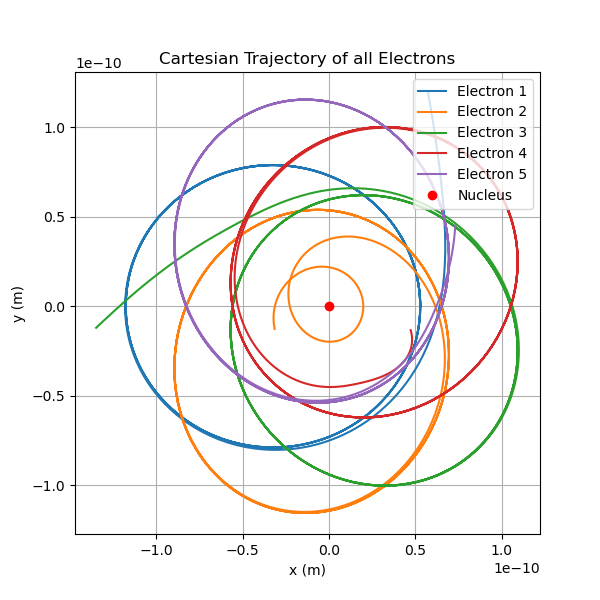

In [25]:
display(test.all_electrons)

**Figure 5.** Alternatively, this is the full cartesian trajectory for all of the electrons during the simulation. Some of the electrons fall into the nucleus and some are ejected. The main takeaway is that once a singular electron in the system is unstable, the orbital system of all of the electrons becomes unstable. Whereas figure 4 displayed the initially periodic behavior of the simulation, it can be seen here that in the long term, this periodicity can be completely broken (i.e., the system destabilizes).

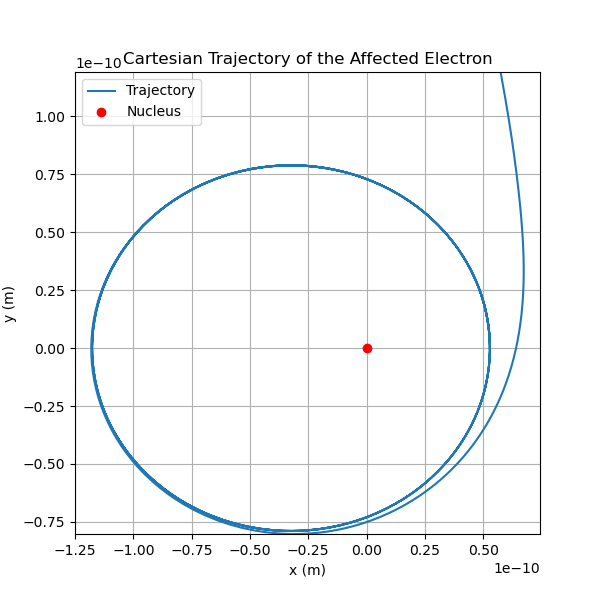

In [26]:
display(test.cartesian_trajectory)

**Figure 6.** Further examining the trajectory of the perturbed electron ("Electron 1" in figure 5, perturbed with a rightward rotation by $10^{-14}$ rad) shows that perturbation produced a non-uniform orbit, being greatly ovular without the nucleus as the center. Thus, we can be certain that the orbit path is still stable for some time, but after a certain point, the incidence electron diverges from the stable path and flies outward.

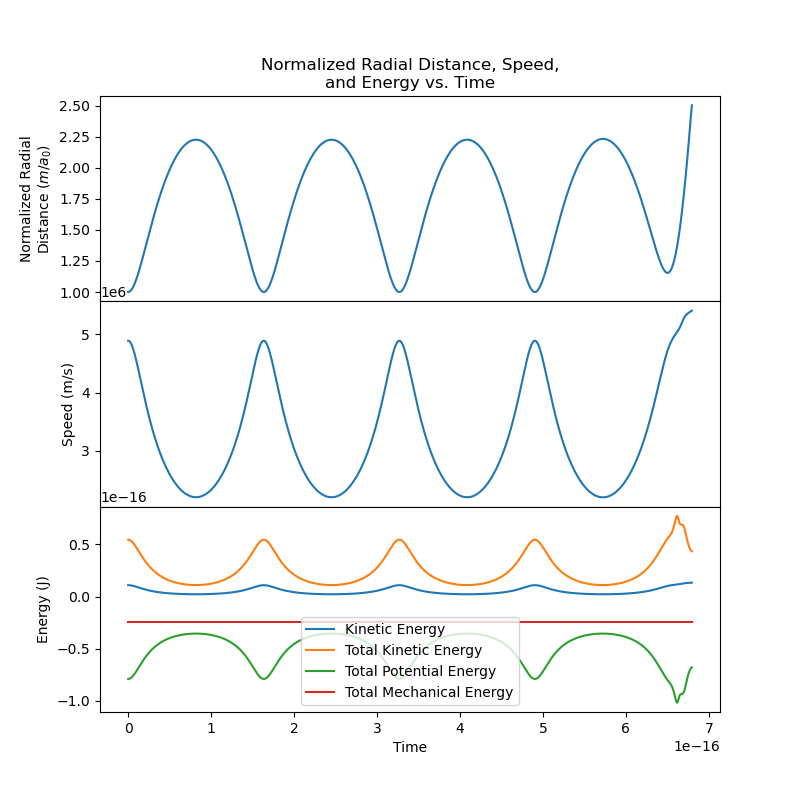

In [27]:
display(test.multipanel)

**Figure 7.** Once more, for a simulation of 5 electrons and given a perturbation of $\theta = -10^{-14}$ radians, the electron maintains periodic behavior in orbit, energy, and speed for a duration of time before destabilizing and becoming unperiodic in all three aspects. Furthermore, we can further verify the correctness of this simulation as the total mechanical energy stays constant. We can also notice how the periodic trend of total kinetic and potential energy across the simulation is maintained up to the orbit breakage point, but even when this point is reached, the total mechanical energy in the system is still kept conserved even despite the orbit breaking, which further validates the simulation's mechanics.

## Exploring the Phase Space of $n$ and $\theta$

**Code Block Summary:** `generate_contour` does exactly as it sounds: this produces a contour by running `calculate` for each `(n,\theta)` and producing the instability score.

In [28]:
def generate_contour(n_domain, theta_domain, debug_print=False):
    """
    Produces the contour of the S(n,theta) phase space given
    a domain of n (the number of electrons) and theta (the
    initial perturbation angle), producing the output stability
    score S (the variance in normalized radial distance).
    """
    A, S = np.meshgrid(n_domain, theta_domain, indexing='ij')
    Z = np.zeros_like(A, dtype=float)
    total_sims = len(n_domain) * len(theta_domain)
    
    # index and interval for debugging purposes:
    idx = 0
    interval = max(total_sims // 10,1)
    
    # explore the phase using nested for
    for i, n in enumerate(n_domain):
        for j, theta in enumerate(theta_domain):
            Z[i,j] = calculate(n, theta).stability_score
            
            # debug print
            idx += 1
            if debug_print and idx % interval == 0:
                print(f'{(idx / total_sims) * 100:.0f}% - Iteration {idx}/{total_sims}')
    
    # plotting
    plt.figure()
    cp = plt.contourf(A, S, Z, levels=20, cmap='viridis')
    plt.colorbar(cp, label='Variance of Bohr Radius Coefficient')
    plt.xlabel('Number of Electrons')
    plt.ylabel('Perturbation Angle (rad)')
    plt.title('Instability vs. ($n,\\theta$)')
    plt.show()

**Code Block Summary:** Now that we've performed some initial tests and know that the simulations work for some general cases, we can produce the contour to take a look at what trend is generated overall to understand the nature between the relationships. Here, `n_domain` is the discrete domain of $n$-values we'll be exploring and `theta_domain` is the discrete domain of $\theta$ values (10 points between $\theta=-10^{-13}$ and $10^{-13}$ rad.)--together, they make our phase space.

10% - Iteration 10/100
20% - Iteration 20/100
30% - Iteration 30/100
40% - Iteration 40/100
50% - Iteration 50/100
60% - Iteration 60/100
70% - Iteration 70/100
80% - Iteration 80/100
90% - Iteration 90/100
100% - Iteration 100/100


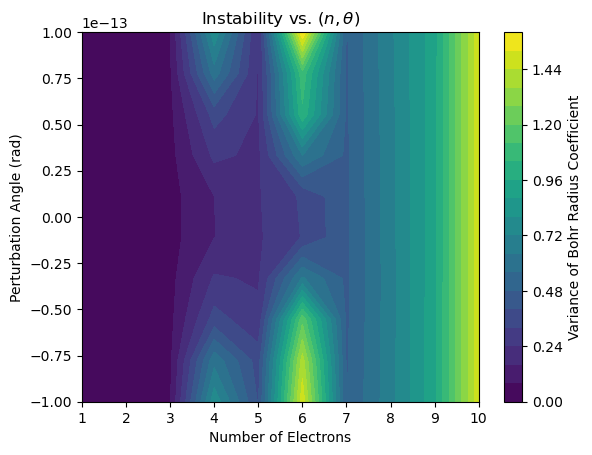

In [29]:
generate_contour(n_domain     = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                 theta_domain = np.linspace(-1e-13, 1e-13, 10),
                 debug_print  = True)

**Figure 8.** The phase space of $n \in \{ 1, 2, \dots, 10 \}$ and $\theta \in \{ -10^{-13}, -7.5 \times 10^{-14}, \dots, 10^{-13} \}$ produces a vertically symmetric contour with four notable patterns: a "sea of stability" between $n=1$ to $n=3$ where nearly all orbits regardless of initial perturbation are completely stable (indicating that for all orbits within the alloted time period of the simulation, they remain stable), relatively stable regions collected toward the horizontal middle of the graph for each $n$ (collected around $\theta=0$, which is reasonable given that the most stable orbits are intuitively the least perturbed), a general trend of greater instability at higher $n$, and two regions of instability at high $\theta$ and roughly $n=4$ and $n=6$, and this is due (most likely) to the orbital geometry at these counts (square and hexagon) being more sensitive to stronger perturbation angles as opposed to more radially spread-out geometries combined with the deviation from the Bohr model predicted in the introduction at these even integer values. Furthermore, this graph is mostly-symmetric, and that is because of the physical interpretation of the turning directions. An electron performing a negative turn is going rightward and leaving the atom whereas the electron with a positive turn is turning leftwrad into the atom, so the difference between repulsion and attraction energies across the two cases are probably not the same due to the differences in distances. This effect is most notable at $n=6$ electrons.

## Edge-Case Exploration

Given the findings of the previous section, it would be most pertinent and helpful to this investigation to explore edge conditions for cases observed within the contour. The three orbit cases $(n,\theta)$ of note for this, therefore, will be $S_1 = (3,10^{-13}), S_2 = (7,10^{-13}),$ and $S_3 = (6,-10^{-13})$:
1. I picked $S_1$ due to it lying on the edge of the aforementioned sea of stability due to being the point at which the computational assumptions deviate from the Bohr model's predictions.
2. I picked $S_2$ due to it lying directly in the middle in a kind of "goldilocks-zone" of stability despite being at a very high $n$ beyond the safety limits of the Bohr model to see the behavior of the model in this region.
3. I picked $S_3$ due to it lying in a region of high instability right after and before two "goldilocks-zones" (local minima of instability scores along $\theta=-10^{-13}$).

### $S_1 = (3, 10^{-13})$ - The Edge of the Sea of Stability

In this test case, we'll be exploring the edge of the "sea of stability" using 3 electrons and a perturbation angle of $10^{-13}$ radians. The purpose of this exploration is to try and visually demonstrate how the periodicity of these models evolves over time to become unstable.

In [30]:
edge_case_1 = simulate(n=3, angle=1e-13)

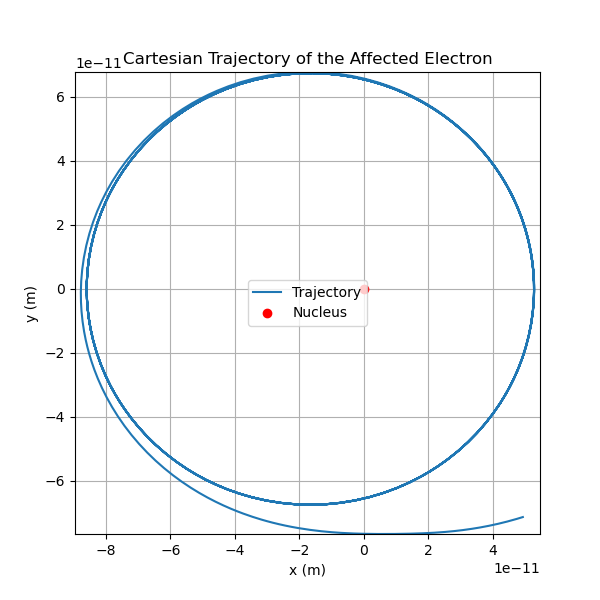

In [31]:
display(edge_case_1.cartesian_trajectory)

**Figure 9.** Naturally, a rightward incidence angle ($\theta > 0$) points out of the radial path, thus why we can observe the electron escaping the orbit of the nucleus. From visual observation, the electron's initial angular incidence is so small that the electron is able to complete one or more entirely stable orbits, but over this simulation, the electron is continuously increasing in radial distance from the nucleus before eventually reaching a far enough distance that the velocity of the electron is above the threshold of the necessary escape velocity at that distance, allowing the electron to escape the orbit.

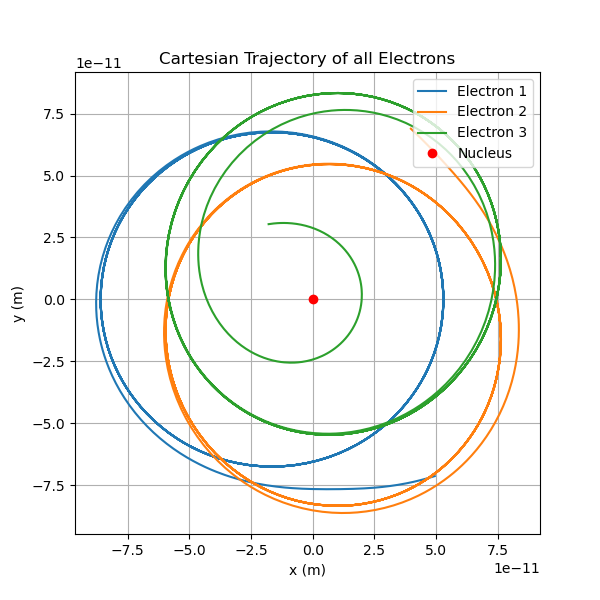

In [32]:
display(edge_case_1.all_electrons)

**Figure 9-1.** The overall system shows the behavior of all of the electrons destabilizing as the incidence electron destabilizes from its orbit. Most interesting, the ejection of the incidence electron still seems to lead one of the electrons to be shot into the nucleus while the other is ejected, and this is probably due to the ejection of the incidence electron leading to an imbalance in the repulsive and attractive energies for the other two electrons.

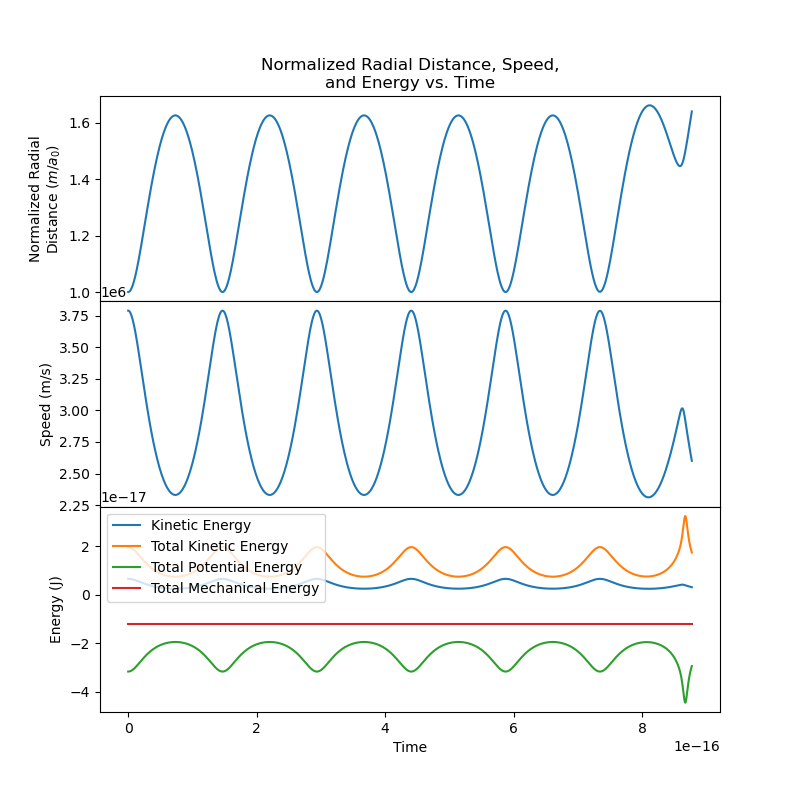

In [33]:
display(edge_case_1.multipanel)

**Figure 10.** The patterns observed by directly plotting the radial distance, speed, and energy as a function of time further proves the conclusions reached from figure 10. The normalized radial distance looks roughly the same for each period (from observing the peaks and troughs), perhaps increasing marginally over its periods of stability, and then over its final orbital period, the electron raises in radial distance so much that its speed becomes high enough to escape the orbit, and this as well is seen by the immediate decrease in the speed graph toward the endpoint. Lastly, the total energy of this simulation is negative and conserved, which is predicted behavior by the Bohr model. 

### $S_2 = (7, 10^{-13})$ - The Goldilocks Zone

In this test case, we'll explore the "Goldilocks Zone" (a local minima of instability on the contour) located at 7 electrons with a perturbation angle of $\theta=10^{-13}$. The purpose of this exploration is similar as before, to witness the time evolution of the periodicity of this simulation to see where and when it becomes unperiodic.

In [34]:
edge_case_2 = simulate(n=7, angle=1e-13)

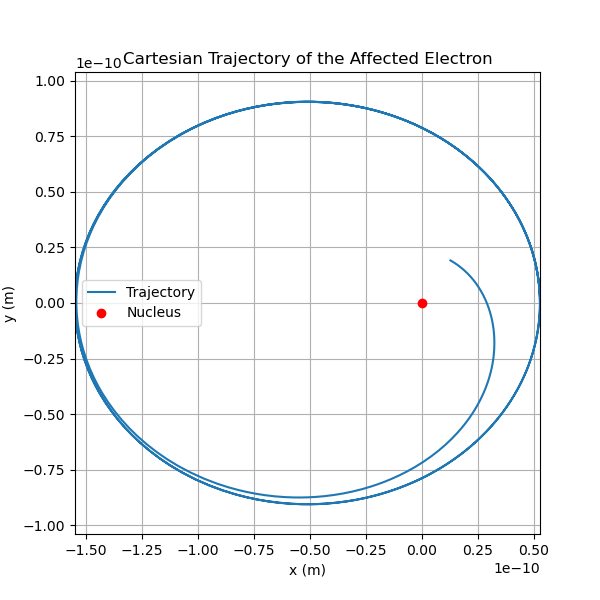

In [35]:
display(edge_case_2.cartesian_trajectory)

**Figure 11.** In this case, we get roughly the same pattern of a seemingly stable orbit over some stability lifetime before the electron deviates off of the stable path. In this case, the electron is now being sucked into the nucleus rather than being ejected, which implies that either the attractive force from the nucleus is stronger than the repulsive force of the other electrons, or, alternatively, the other electrons in the system have other, distinct orbital patterns from the incidence electron (which is predicted behavior by the Bohr model as well) that would cause the repulsive force to push the electron into the nucleus due to a misalignment.

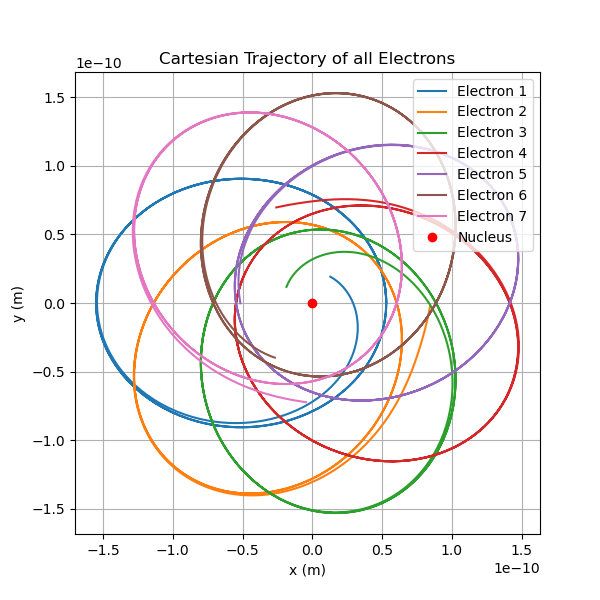

In [36]:
display(edge_case_2.all_electrons)

**Figure 11-1.** With more electrons in the simulation, the behavior becomes more complex compared to the previous edge case, so now, multiple electrons (electrons 1, 3, 6, and 7) are being sucked into the nucleus and the rest are ejected from the atom within the explored time scale.

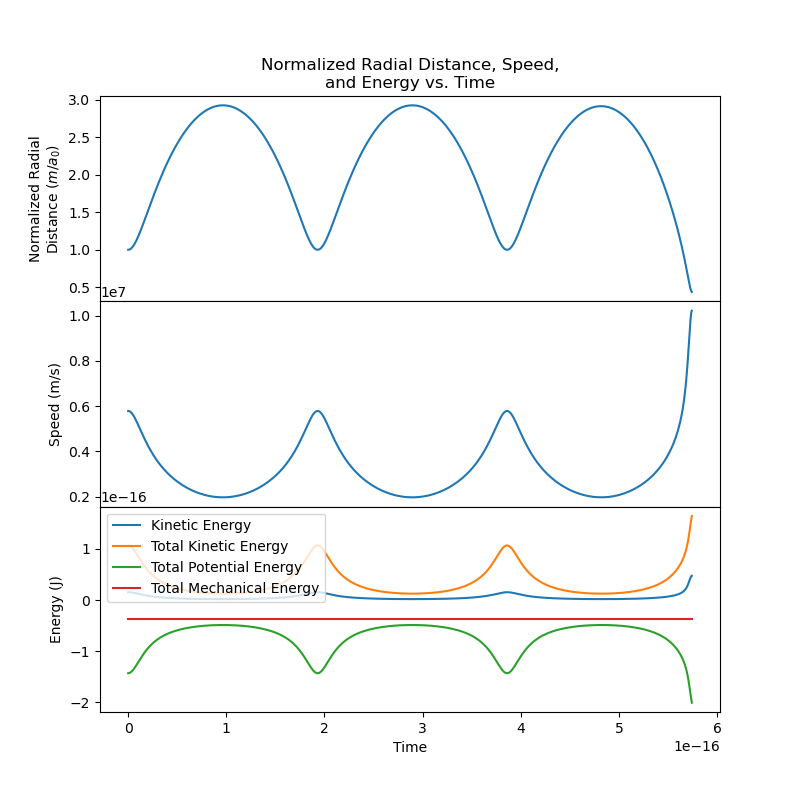

In [37]:
display(edge_case_2.multipanel)

**Figure 12.** The total energy of the system is negative and conserved, which is predicted behavior because the net repulsive energy between the electrons is greater than the kinetic energy of the electrons. Additionally, the total kinetic energy of the system increases as the electron accelerates towards the nucleus (alongside a matching decrease in potential energy), a behavior which is also expected because as the system's orbit destabilizes, all of the electrons in the system begin to rapidly get either ejected from the atom or sucked into the nucleus, and in both scenarios, the electrons speed up quickly.

### $S_3 = (6, -10^{-13})$ - A Peak of Instability

In this test case, we'll explore the peak of instability (a local maxima) located at the brightest yellow local fringe at $n=6$, $\theta=-10^{-13}$ radians on the contour. The purpose of this simulation is much like the previous two: to see the time-evolution of the periodicity of this simulation to determine how it becomes unperiodic over time.

In [38]:
edge_case_3 = simulate(n=6, angle=-1e-13)

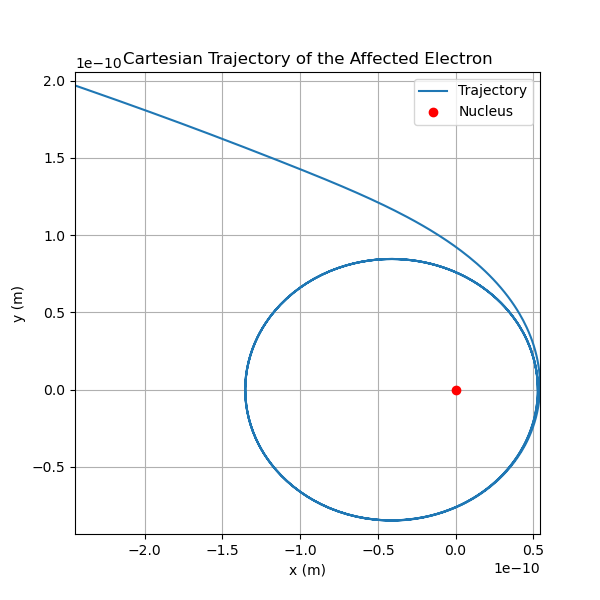

In [39]:
display(edge_case_3.cartesian_trajectory)

**Figure 13.** In this case, one would expect the electron to fall into the nucleus due to the incidence angle being leftward ($\theta < 0$), however, the electron falls out of the orbital range, implying that the incidence angle is likely more indicative for whether or not the electron falls into the nucleus or is ejected based on the ratio between the magnitude of the incidence angle and the number of electrons in the system due to the differences between the attraction and repulsion energy and the geometry of the other orbits in the system.

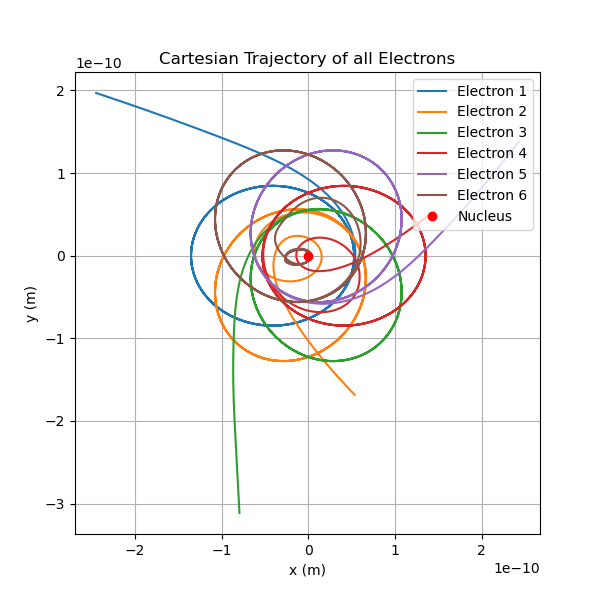

In [40]:
display(edge_case_3.all_electrons)

**Figure 13-1.** The full trajectories for this simulation reveals the long-run behavior of the electrons after having been sucked into the nucleus or shot out of the atom. Most of the electrons that are sucked into the nucleus are quickly shot right out, quite like a cannon, and the electrons that are shot out of the atom proceed to make quite a long distance out of the atom during the time scale. However, one electron (electron 6) actually continues to orbit the nucleus towards the end of the simulation as all of the other electrons had been ejected, so it becomes more like an orbital case with one electron and 6 protons stored in a singular nucleus, making the attractive energy so strong that escape is fairly unlikely.

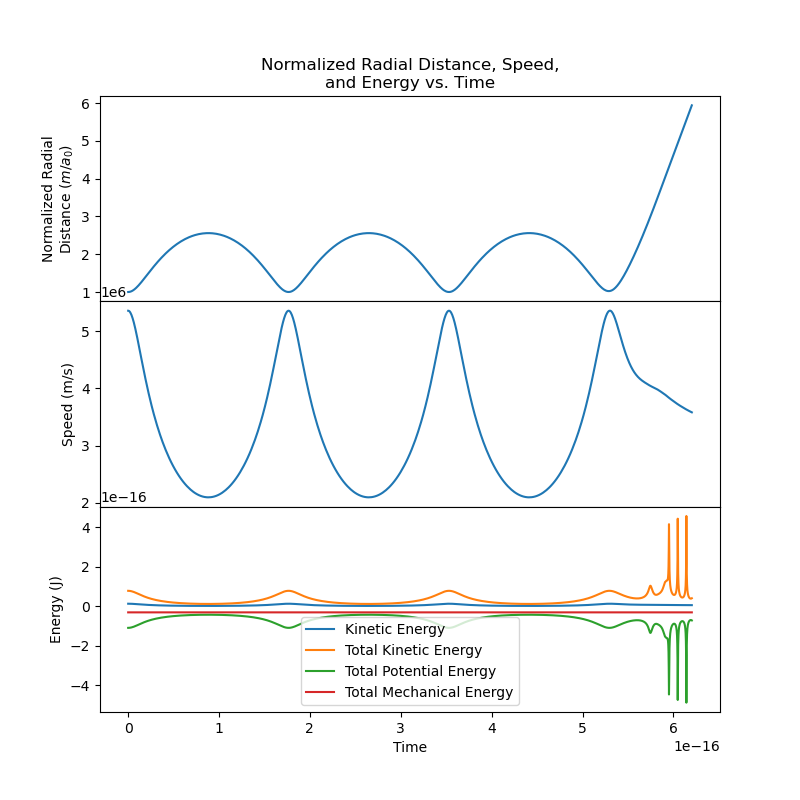

In [41]:
display(edge_case_3.multipanel)

**Figure 14.** Even as the electron falls out of the stable orbit of the nucleus, it still observes periodic behavior in the potential and kinetic energies (implying that the electron experiences interference with other electrons in the system as it leaves).

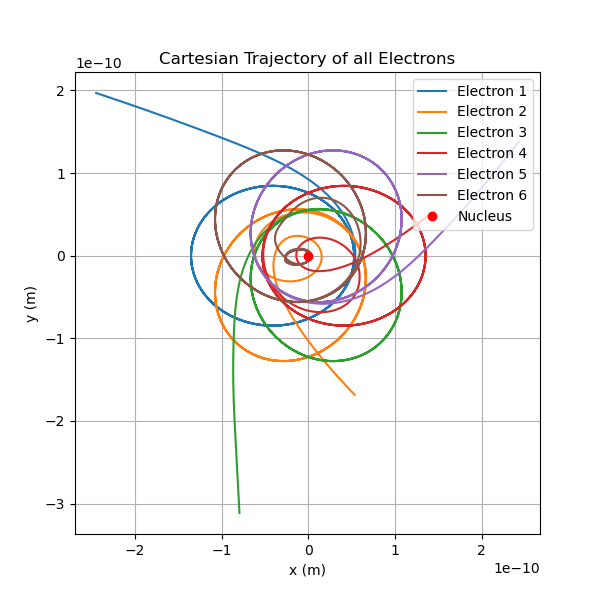

In [42]:
display(edge_case_3.all_electrons)

**Figure 15.** This simulation produces something of a "spaghetti mess" as a result of the incredibly high instability. Generally, all of the electrons are stable for at least a period or two, but then, many are sucked into the nucleus and then quickly ejected out of the atom entirely. As such, as can conclude that this atom, in its entirety, is completely unstable.

## Summary of Findings

### Conclusion

1. A system of orbits for degenerate electrons becomes considerably more unstable for higher counts of electrons, likely due to the increasingly higher deviation from literature predictions without more complex models like valence shells, orbitals, and so on.
2. Certain radially symmetric orbital geometries, particularly at $n=4$ or $n=6$ where the model is firmly out-of-line with the full classical saturnian model and an even number of electrons, are more sensitive to perturbation by the turning of a singular electron in the system. 
3. Once the system reaches $n=7$ electrons, the system can be said to be cluttered or overly-dense with electrons. At this point, the repulsion energy between the electrons is so high that the system will quickly become unperiodic, and increasing $n$ from this point makes the systems increase in instability without respect to the angle of perturbation, and this is proven by how figure 8 is vertically uniform at $n=7$ and beyond.

### Limitations

1. By far, the biggest limitation of this model is the exclusion of non-circular orbits. This model makes no investigation into (or consideration of) non-uniform orbits, indicating that this model is extremely sensitive to the initial conditions and lacks the ability to consider the limits of stability for far more generally-applicable cases. 
2. Additionally, this model only measures short-term time intervals, meaning that long-term stability cannot be measured for orbits which become unstable only over incredibly long time intervals (i.e., much shorter initial perturbations). 
3. Lastly, the third largest limitation of this model is its deviation from the Bohr model due to all electrons in the system being degenerate and having no inclusion for the Aufbau or the Pauli exclusion principles, which means that all experimental results are only generally understandable from the perspective of orbital mechanics but not trustable for electron mechanics.

### Future Work

Based on the limitations of this project, some of the most interesting extension questions to explore from this project are

1. If we define orbital stability as the length of time in seconds that an orbit is able to remain periodic, what is the rate of change of the orbital stability as a function of the perturbation angle for ultra-stable systems (i.e., trivial/near-trivial $n \in [1, 3]$ and perturbation angles approaching zero, such as $\theta \le 10^{-20}$)? 
2. Suppose we implement the full classical atomic model, including the Bohr model, Aufbau's principle, and the Pauli exclusion principle. Define error between this model and full model as the deviation between the calculations for orbital stability. What is the rate of change of the error with respect to the number of electrons in the system?
3. This model assumes that all of the atoms have an equal number of protons and electrons for the sake of stability. However, what kinds of orbits will be observed for ions, with $Z \neq N$? What is the rate of change in orbital stability as a function of the difference in $Z$ and $N$?
4. This model is strictly two-dimensional, but electron orbits are three-dimensional. What differences in orbital stability patterns can be observed in a more realistic two-dimensional incidence vector $\langle \theta, \phi \rangle$ at a given $n$?

## Bibliography

[1] Bohr, Neils. "On the Constitution of Atoms and Molecules." https://people.isy.liu.se/jalar/kurser/QF/references/Bohr1913I.pdf

[2] https://docs.python.org/3/library/dataclasses.html

[3] https://docs.python.org/3/library/io.html

[4] Pillow: Python Imaging Library https://pypi.org/project/pillow/

# Appendix

## Validation Tasks

**Validation A: Unit Testing**

Each core task within the simulation is broken up heavily into individual functions, and then for each function, I've been able to write tests to ensure that they are working exactly as intended. Simple subroutines like helper functions have very strict tasks (as I can expect exact values, such as rotating predefined vector by a predefined angle) and more complicated subroutines like performing a full calculation or calculating the orbital stability allow for more complicated tests. Each test will have, at the very least, a test for extreme, "trivial" cases (like perfect circular motion or linear motion). For example:

```python
def rotate_vector_2d(vec, theta):
    """
    Rotates vector `vec` counterclockwise by `theta` radians
    """
    rotation_matrix = \
        np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    rotation_matrix[np.abs(rotation_matrix) < 1e-15] = 0
    return rotation_matrix @ vec

def test_rotate_vector_2d():
    ihat = np.array([1,0])
    jhat = np.array([0,1])
    
    # Rotating (1,0) by 90 deg counter clockwise should give (0,1)
    assert_allclose(rotate_vector_2d(ihat,  np.pi/2), jhat, atol=1e-6)
    # And vice versa
    assert_allclose(rotate_vector_2d(jhat, -np.pi/2), ihat, atol=1e-6)
    
    # realistic velocity case
    v = 4e16
    vec0 = np.array([0,v])
    rotated = np.array([v,0])
    
    assert_allclose(rotate_vector_2d(vec0, -np.pi/2), rotated, rtol=1e-10)
    
    print('(Test) `rotate_vector_2d` successful')
    
test_rotate_vector_2d()
```

In [43]:
def test_rotate_vector_2d():
    ihat = np.array([1,0])
    jhat = np.array([0,1])
    
    # Rotating (1,0) by 90 deg counter clockwise should give (0,1)
    assert_allclose(rotate_vector_2d(ihat,  np.pi/2), jhat, atol=1e-6)
    # And vice versa
    assert_allclose(rotate_vector_2d(jhat, -np.pi/2), ihat, atol=1e-6)
    
    # realistic velocity case
    v = 4e16
    vec0 = np.array([0,v])
    rotated = np.array([v,0])
    
    assert_allclose(rotate_vector_2d(vec0, -np.pi/2), rotated, rtol=1e-10)
    
    print('(Test) `rotate_vector_2d` successful')
    
test_rotate_vector_2d()

(Test) `rotate_vector_2d` successful


In [44]:
def test_unit_vector():
    v1 = np.array([1,0])
    assert_allclose(unit_vector(v1), v1)
    v2 = np.array([1,1])
    assert_allclose(unit_vector(v2), v2/np.sqrt(2))
    print('(Test) `unit_vector` successful')
    
test_unit_vector()

def test_magnitudes():
    vs = np.array([[1,0],[0,1],
                   [1/np.sqrt(2),1/np.sqrt(2)],
                   [4/np.sqrt(2),4/np.sqrt(2)]])
    test = magnitudes(vs)
    assert_allclose(test, np.array([1, 1, 1, 4]))
    print('(Test) `magnitudes` successful')
    
test_magnitudes()

(Test) `unit_vector` successful
(Test) `magnitudes` successful


In [45]:
def test_cartesian_to_polar():
    test1 = cartesian_to_polar([
        [ 1,   np.sqrt(2)/2,   0,       -np.sqrt(2)/2,   -1,    -np.sqrt(2)/2,    np.sqrt(2)/2,   1       ],
        [ 0,   np.sqrt(2)/2,   1,        np.sqrt(2)/2,    0,    -np.sqrt(2)/2,   -np.sqrt(2)/2,   0       ]])
    answer1 = np.array([
        [ 1,   1,              1,        1,               1,     1,               1,              1       ], 
        [ 0,   np.pi/4,        np.pi/2,  3*np.pi/4,       np.pi, 5*np.pi/4,       7*np.pi/4,      2*np.pi ]])
    assert_allclose(test1, answer1)
    print('(Test) `cartesian_to_polar` successful')
    
test_cartesian_to_polar()

(Test) `cartesian_to_polar` successful


In [46]:
def test_interpret_state():
    example_state = [ 1, 2, 3, 4 ]
    interpretation = interpret_state(example_state)
    assert_allclose(interpretation.pos, np.array([1, 2]))
    assert_allclose(interpretation.vel, np.array([3, 4]))
    print('(Test) `interpret_state` successful')
    
test_interpret_state()

(Test) `interpret_state` successful


In [47]:
def test_set_state_index():
    example_state = np.zeros(12)
    set_state_index(example_state, 1, np.array([1, 2]), np.array([3, 4]))
    assert_allclose(example_state, np.array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0]))
    print('(Test) `set_state_index` successful')

test_set_state_index()

(Test) `set_state_index` successful


In [48]:
def test_get_state():
    example_state = np.array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0])
    test = get_state(example_state, 1)
    assert_allclose(test, np.array([1, 2, 3, 4]))
    print('(Test) `get_state` successful')
    
test_get_state()

(Test) `get_state` successful


In [49]:
def test_get_electron():
    example_state = np.array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0])
    test = get_electron(example_state, 1)
    assert_allclose(test.pos, np.array([1, 2]))
    assert_allclose(test.vel, np.array([3, 4]))
    print('(Test) `get_electron` successful')
    
test_get_electron()

(Test) `get_electron` successful


In [50]:
def test_calculate_coulomb_force():
    # electron-proton
    electron_pos = np.array([bohr_radius, 0])
    proton_pos   = np.array([0,  0])
    
    distance_vec  = electron_pos - proton_pos
    answer        = np.array([-k * q ** 2 / bohr_radius ** 2, 0])
    force_attract = calculate_coulomb_force(distance_vec, attract=True)
    assert_allclose(force_attract, answer)
    
    # electron-electron
    other_electron_pos = np.array([0, bohr_radius])
    distance_vec_2     = electron_pos - other_electron_pos
    answer_2           = (k * q ** 2) / (2 ** (3/2) * bohr_radius ** 2) * np.array([ 1, -1 ])
    force_attract_2    =  calculate_coulomb_force(distance_vec_2, attract=False)
    assert_allclose(force_attract_2, answer_2)
    
    print('(Test) `calculate_coulomb_force` successful')
    
test_calculate_coulomb_force()

(Test) `calculate_coulomb_force` successful


In [51]:
def test_generate_initial_state():
    r0, v0, _ = calculate_starting_values(1)
    
    trivial, _ = generate_initial_state(1)
    assert_allclose(trivial, np.array([r0, 0, 0, v0]))
    
    incidence_angle, _ = generate_initial_state(1, -np.pi/2)
    assert_allclose(incidence_angle, np.array([r0, 0, v0, 0]), atol=1e-6)
    
    # n=4 test
    r, v, _ = calculate_starting_values(4)
    
    higher_n, _ = generate_initial_state(4, 0)
    assert_allclose(higher_n, np.array([
         r,  0,  0,  v,
         0,  r, -v,  0,
        -r,  0,  0, -v,
         0, -r,  v,  0
    ]), atol=1e-6)
    print('(Test) `generate_initial_state` successful')
    
test_generate_initial_state()

(Test) `generate_initial_state` successful


In [52]:
def test_calculate_starting_values():
    # Trivial Case, N=0
    f_trivial = k * q ** 2 / bohr_radius ** 2
    a_trivial = f_trivial / m
    v_trivial = np.sqrt(a_trivial * bohr_radius)
    T_trivial = 2 * np.pi * bohr_radius / v_trivial
    
    trivial = calculate_starting_values(1)
    assert_allclose(trivial, (bohr_radius, v_trivial, T_trivial), atol=1e-6)
    
    # n=5 case
    radius_5, v_5, T_5 = calculate_starting_values(5)
    
    assert_allclose(radius_5, bohr_radius, atol=1e-12)
    assert_allclose(T_5, 2*np.pi*radius_5 / v_5, atol=1e-12)
    
    # Optional: check that speed is positive
    assert v_5 > 0
    
    print('(Test) `calculate_starting_values` successful')
    
test_calculate_starting_values()

(Test) `calculate_starting_values` successful


In [53]:
def test_calculate_orbital_stability():
    # trivial case: roughly constant movement
    trivial_polar_trajectory = np.array([[5.29e-11, 5.29e-11, 5.29e-11, 5.29e-11, 5.29e-11, 5.289999999999999e-11, 5.2899999999973413e-11, 5.2899999999719824e-11, 5.289999999904584e-11, 5.2899999997796087e-11, 5.28999999958277e-11, 5.289999999300002e-11, 5.289999998917059e-11, 5.289999998419584e-11, 5.289999997793806e-11, 5.289999997028217e-11, 5.289999996116759e-11, 5.289999995063784e-11, 5.289999993889987e-11, 5.2899999926362346e-11, 5.289999991360713e-11, 5.289999990127884e-11, 5.289999988994644e-11, 5.28999998800157e-11, 5.289999987171765e-11, 5.289999986514268e-11, 5.2899999860282325e-11, 5.2899999857059946e-11, 5.289999985534643e-11, 5.289999985496092e-11, 5.2899999855915115e-11, 5.289999985719548e-11, 5.28999998588157e-11, 5.289999986069596e-11, 5.2899999862753236e-11, 5.289999986491182e-11, 5.289999986708935e-11, 5.289999986919218e-11, 5.2899999871116155e-11, 5.289999987275406e-11, 5.289999987401327e-11, 5.289999987484802e-11, 5.2899999875306316e-11, 5.2899999875577385e-11, 5.289999987600475e-11, 5.289999987703012e-11, 5.289999987908029e-11, 5.289999988246331e-11, 5.289999988732759e-11, 5.2899999893678385e-11, 5.289999990141505e-11, 5.289999991036183e-11, 5.28999999202814e-11, 5.28999999308672e-11, 5.28999999408741e-11, 5.2899999949976136e-11, 5.289999995889427e-11, 5.289999996971825e-11, 5.2899999981745804e-11, 5.2899999994580144e-11, 5.290000000792483e-11, 5.290000002151796e-11, 5.290000003510601e-11, 5.290000004843437e-11, 5.290000006125017e-11, 5.290000007331913e-11, 5.290000008446012e-11, 5.290000009459588e-11, 5.290000010380191e-11, 5.2900000112316153e-11, 5.290000012047937e-11, 5.290000012862942e-11, 5.2900000137014274e-11, 5.2900000145763357e-11, 5.2900000154903896e-11, 5.290000016439001e-11, 5.2900000174124536e-11, 5.290000018396657e-11, 5.2900000193720865e-11, 5.290000020223265e-11, 5.2900000210668355e-11, 5.2900000218743033e-11, 5.290000022757767e-11, 5.290000023660492e-11, 5.2900000245424125e-11, 5.2900000253700546e-11, 5.290000026112707e-11, 5.290000026740949e-11, 5.2900000272265865e-11, 5.2900000275439964e-11, 5.2900000276732744e-11, 5.2900000276054094e-11, 5.290000027348515e-11, 5.290000026931802e-11, 5.2900000264027805e-11, 5.290000025816704e-11, 5.290000025223911e-11, 5.2900000246621935e-11, 5.2900000241558723e-11, 5.290000023718632e-11, 5.290000023356913e-11, 5.290000023072451e-11, 5.2900000228637335e-11, 5.290000022795886e-11, 5.290000022793263e-11], [0.0, 4.5709565840908357e-07, 5.028052242499919e-06, 5.073761808340828e-05, 0.0005078332764924918, 0.005078789860583328, 0.033078592317969564, 0.07383649980839826, 0.12173945595832007, 0.17473115212782908, 0.23176074318336662, 0.29219194595131487, 0.35559780065603397, 0.4216663371588204, 0.4901452819485468, 0.5608001585897692, 0.6333746032741164, 0.7075495111998448, 0.7829067109069743, 0.8589140640252676, 0.9349522775381844, 1.0103840754389675, 1.0846323290670932, 1.1572245064723738, 1.2277889940964994, 1.2960182890262963, 1.36161836883082, 1.4242508579574853, 1.4834570072831368, 1.5385219190862651, 1.5791425257819725, 1.619732383816372, 1.6638470532062797, 1.7140370666466795, 1.7688055894112389, 1.8273127256250836, 1.8890251961202509, 1.9535722354996883, 2.020672295730845, 2.0900853077098125, 2.1615725834820045, 2.2348566120687967, 2.3095807555089434, 2.3852792253461823, 2.461377571714341, 2.537239032584537, 2.6122430141025093, 2.68585335630041, 2.7576423701451795, 2.827270715521759, 2.8944430326288844, 2.9588544463625595, 3.0201276861416053, 3.077720261693007, 3.1242994954417016, 3.164120223936089, 3.20189186253784, 3.247880502589437, 3.299436956926098, 3.355297251303575, 3.4147276090967553, 3.477249322747796, 3.5425218177279922, 3.6102791292528957, 3.6802854795265016, 3.7522956141017825, 3.8260141929844362, 3.9010567678787496, 3.9769258941342374, 4.053023497178312, 4.128708994584555, 4.203379660398109, 4.276528822321785, 4.347756436769687, 4.416740184129794, 4.48318766970435, 4.546781103612565, 4.607109388729472, 4.663558787950962, 4.707694592960023, 4.751801790970031, 4.7940585174974295, 4.842944987764339, 4.896692712733651, 4.954347075787226, 5.0153178826505656, 5.079203147975567, 5.145704563544826, 5.214575759988981, 5.285581348351101, 5.3584570634719055, 5.432868978012786, 5.508379380690835, 5.584437820520707, 5.660416122610269, 5.7356822913514005, 5.80967544451556, 5.881941933578346, 5.952124417933594, 6.019921529821969, 6.0850359816558255, 6.147114937098614, 6.2056679995120785, 6.254094608791819, 6.283185304281992]])
    trivial_time = np.array([0.0, 1.105274277769807e-23, 1.2158017055467877e-22, 1.2268544483244859e-21, 1.2279597226022557e-20, 1.2280702500300326e-19, 7.998526470614325e-19, 1.785393986953936e-18, 2.9437052569627915e-18, 4.2250641504700545e-18, 5.604060841839397e-18, 7.065309767573334e-18, 8.598486881662407e-18, 1.0196048630208628e-17, 1.1851894945924015e-17, 1.3560356101406e-17, 1.5315233124435598e-17, 1.7108809942271246e-17, 1.8930975013597186e-17, 2.076886103491787e-17, 2.260749327108052e-17, 2.443146215162082e-17, 2.6226812491309246e-17, 2.7982118292263276e-17, 2.968839380081837e-17, 3.133820348252506e-17, 3.292443776599791e-17, 3.443891460489402e-17, 3.58705412752304e-17, 3.7202031284803265e-17, 3.818425263459774e-17, 3.9165730470387024e-17, 4.0232439553357107e-17, 4.1446052710961845e-17, 4.277037592385937e-17, 4.418510019801054e-17, 4.567733064517087e-17, 4.723810202040068e-17, 4.886060638774642e-17, 5.0539038787137875e-17, 5.226762765519746e-17, 5.403966267340371e-17, 5.584652020341403e-17, 5.767693730739744e-17, 5.9517023574307e-17, 6.13513818618972e-17, 6.316500598042233e-17, 6.494493138288559e-17, 6.668081638977837e-17, 6.836445563122802e-17, 6.998870719766333e-17, 7.15461990959372e-17, 7.302780878335633e-17, 7.442041864369993e-17, 7.554672181052794e-17, 7.650960181122802e-17, 7.742293405779288e-17, 7.853495645092897e-17, 7.978161066148385e-17, 8.11323333230284e-17, 8.256938144440605e-17, 8.40811796991949e-17, 8.565949286888694e-17, 8.729788982627133e-17, 8.899066937670115e-17, 9.073190117655944e-17, 9.251444379506501e-17, 9.432900112958564e-17, 9.616354478364189e-17, 9.800361309185409e-17, 9.983371653315581e-17, 1.0163928097004196e-16, 1.0340805487814655e-16, 1.0513036505496056e-16, 1.0679841769253493e-16, 1.0840514257845538e-16, 1.099428554353336e-16, 1.1140161578193453e-16, 1.12766583227021e-16, 1.1383380338968465e-16, 1.1490033182482267e-16, 1.1592211517231686e-16, 1.1710420818702917e-16, 1.1840384814707687e-16, 1.1979795206801002e-16, 1.2127224883301202e-16, 1.2281701828700386e-16, 1.2442504722641827e-16, 1.2609037834830143e-16, 1.2780731986012132e-16, 1.295694817320141e-16, 1.3136878947671067e-16, 1.331946590725921e-16, 1.350337804101494e-16, 1.368709639869574e-16, 1.3869092791430807e-16, 1.4048010985149114e-16, 1.4222754040865425e-16, 1.4392457895722463e-16, 1.4556393831288031e-16, 1.4713842995137345e-16, 1.486395221590688e-16, 1.500553569631224e-16, 1.5122633036791133e-16, 1.5192975419319306e-16])
    trivial_stability = calculate_orbital_stability(trivial_time, trivial_polar_trajectory)
    
    # this value should be reasonably low
    print('Trivial Case Stability:', trivial_stability)
    
test_calculate_orbital_stability()

Trivial Case Stability: 7.753245385122206e-18


**Validation B: By-Hand Calculations**

For the sake of validation, we can consider the calculations produced for the trivial case $n=1$ and $\theta=0$.

In [54]:
trivial_case = simulate(n=1, angle=0)

Firstly, we should verify that the trivial case is truly trivial, i.e., it's a completely uniform orbit, and we can validate this based on the instability score being roughly zero:

In [55]:
trivial_case_instability = trivial_case.calc.stability_score
print(f'Stability Score: {trivial_case_instability:.3e}')

Stability Score: 1.623e-16


The instability score is $S(1,0) = 1.6 \times 10^{-16} \approx 0$, so we know that that is correct. Next, we should verify that the total mechanical energy (TME) in the system is conserved in much the same way by calculating the variance of the TME normalized by the mean TME is also approximately zero:

In [56]:
trivial_case_energy_dev = np.var(trivial_case.calc.total_mechanical_energy)/np.mean(trivial_case.calc.total_mechanical_energy)
print(f'Instability Score: {trivial_case_energy_dev:.3e}')

Instability Score: -3.398e-34


We can also verify that the speed of the electron matches Bohr predictions by equation [1]
$$v_n = \frac{nh}{2\pi m_e r_n}$$
which becomes
$$v_1 = \frac{h}{2\pi m_e a_0} \approx 2.188 \times 10^{6} \text{ m/s}$$
where $h=6.626 \times 10^{-34}$ $m^2 kg/s$, $m_e = 9.109 \times 10^{-31}$ $kg$, and $a_0 = 5.29 \times 10^{-11}$ $m$. Furthermore, the speed should stay roughly constant at this value.

In [57]:
trivial_velocity = trivial_case.calc.electrons[0].vel
trivial_speed = np.linalg.norm(trivial_velocity,axis=0)
trivial_avg_speed = np.mean(trivial_speed)
trivial_avg_speed_dev = np.var(trivial_avg_speed)/trivial_avg_speed
print(f'Average Speed: {trivial_avg_speed:.3e} m/s')
print(f'Normalized Variance in Average Speed: {trivial_avg_speed_dev:.3e}')

Average Speed: 2.188e+06 m/s
Normalized Variance in Average Speed: 0.000e+00


Therefore, because $\overline{v} \approx v_1$ and $\frac{\Delta v}{\overline{v}} \approx 0$, we know that the speed mechanics are completely correct.

This value is $\frac{\Delta E}{\overline{E}} = -3.4 \times 10^{-34} \approx 0$, so the total mechanical energy of the simulation is also conserved. Lastly, we can verify that angular momentum is conserved, and we know that this should be equal to roughly $$|\mathbf{L}| = |rm\mathbf{v}| = a_0 m_e v_1 \approx 1.05 \times 10^{-34} \text{ } kg \cdot m^{2}/s,$$ where $a_0$ is the Bohr radius, $m_e$ is the mass of an electron, and $v_1 = 2.18 \times 10^6$ is the velocity of the lone electron for ground-state Hydrogen 

In [58]:
trivial_radius = np.linalg.norm(trivial_case.calc.electrons[0].pos,axis=0)
trivial_rot_inertia = trivial_radius * m * trivial_speed
avg_trivial_rot_inertia = np.mean(trivial_rot_inertia)
trivial_rot_inertia_var = np.var(trivial_rot_inertia)/avg_trivial_rot_inertia
print(f'Average Rotational Intertia: {avg_trivial_rot_inertia:.3e} kgm^2/s')
print(f'Normalized Variance: {trivial_rot_inertia_var:.3e}')

Average Rotational Intertia: 1.053e-34 kgm^2/s
Normalized Variance: 4.108e-51


Therefore, as $\overline{L} = 1.05 \times 10^{-34}$ $kg \cdot m^2/s$ and $\Delta L/\overline{L} = 4.1 \times 10^{-51} \approx 0$, we know that angular momentum was successfully conserved and matches the literature expectations.

Now, we can match the total energy in the system to the expectations by the Bohr model [1] $$E_n = \frac{-13.6}{n^2} \text{ } eV$$ for ground state Hydrogen as $E_1 = -13.6$ $eV$, knowing that $1$ $eV = 1.602 \times 10^{-19}$ $J$:

In [59]:
trivial_energy = np.mean(trivial_case.calc.total_mechanical_energy)/(1.602e-19)
print(f'Total Mechanical Energy: {trivial_energy:.3f} eV')

Total Mechanical Energy: -13.594 eV


So, therefore, experimentally, the total energy present in the system was $\approx -13.6$ $eV$!

**Validation C: Situational Intuition**

We can reasonably intuit that certain situations should have varying stability with respect to each other. For example, the trivial case of $n=1$ should be the most stable orbit whereas $n=10$, well outside an agreeable simulation with theoretical predictions, should be much more unstable, i.e., $S(1,0) <<< S(10,0)$:

In [60]:
s10 = simulate(n=10, angle=0)

In [61]:
print(f'S(1,0)={trivial_case_instability:.3e}')
print(f'S(10,0)={s10.calc.stability_score:.3f}')

S(1,0)=1.623e-16
S(10,0)=1.496


So, therefore, $S(10,0)$ is about $10^{16}$ times larger than $S(0,0)$, which matches our expectations. 

For another potential situation, we know that $S$ is extremely sensitive to $\theta$, so far a $\theta$ beyond the phase domain we explored previously, should produce extremely high instability, so let's assume $n=2$ and $\theta = -\pi/2$. Now, we can see what occurs:

In [62]:
turn = simulate(n=2, angle=-np.pi/2)

In [63]:
print(f'S(2,pi/2)={turn.calc.stability_score:.3f}')

S(2,pi/2)=58.328


As we can see, this implies that the electron not only escapes the orbit of the nucleus, but it reaches a distance of almost $58 a_0$ away from the nucleus because it begins turning completely away from the electron entirely, and the repulsion from the additional electron allows it to completely escape the orbit.

## Reflection Questions

### B-1. Coding Approaches (A)

> How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise. Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. Reflect on any unforeseen coding challenges you faced in completing this project.

My coding style for python utilizes the following rules:

1. Break all program sections into minimally-sized subroutines and provide unit tests for each subroutine, with at least the most trivial (extreme) cases for each function. Similarly, break down repeatedly-used datatypes into classes or structures (dataclasses). For example, instead of writing
```python
def perform_simulation(n,theta):
    circle = np.linspace(0, 2 * np.pi, n, endpoint=False)
    initialstate = [ [r0 * np.cos(ang), r0 * np.sin(ang), v0 * cos(theta), v0 * sin(theta)] \
                     for ang in circle ]
    def diff_eqns(t, state):
        for i in range(n):
            f=k*q**2/r0**2 + ...
```
I would instead write something like
```python
@dataclass
class Electron:
    pos: np.array
    vel: np.array

def calculate_initial_state(n, theta):
    state = []
    circle = np.linspace(0, 2 * np.pi, n, endpoint=False)
    for ang in circle:
        pos = r0 * np.array([np.cos(ang), np.sin(ang)])
        vel = rotate_vector(np.array([0, v0]), ang)
        state.append([pos[0], pos[1], vel[0], vel[1]])
    return state
    
def test_calculate_initial_state(n, theta):
    # trivial test n=1
    ...

def get_electron(i, state):
    ...
    
def test_get_electron():
    ...
    
def calculate_coulomb_force(electron):
    ...
    
def test_calculate_coulomb_force():
    ...
    
def perform_simulation(n, theta):
    initial_state = calculate_initial_state(n, theta)
    
    def diff_eqns(t, state):
        for i in range(n):
            f = calculate_coulumb_force(get_electron(i, state))
    
```
which creates much more code (so it can seem a bit bulky to read), but it verifies that the subroutines are correct.

2. Calculate graphics together and *store* them to display and discuss them at later, distinct times (for simplicity). I ritually use the function

```python
def save_graph_and_close():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    graph = Image.open(buf)
    plt.close()
    return graph
```
and I utilize it in my graphing sections each and every time I need to plot multiple things:
```python
    # Cartesian Trajectory
    plt.plot(affected_electron.pos[0], 
             affected_electron.pos[1], label='Trajectory')
    ...
    figures.cartesian_trajectory = save_graph_and_close()

    # Speed vs. Time
    plt.figure()
    ...
    figures.speed_graph = save_graph_and_close()
```

3. Use explicit (potentially long/wide) variable and function names and limit inline comments beyond what is absolutely necessary. I.e., prefer simplicity in comments through detail in code and not the other way around. Avoid inline mathematical notation (especially non-UTF characters) as much as possible. I find it much easier to read this way. For example, take `generate_initial_state`. Rather than writing it as
```python
def generate_initial_state(n, θi=None):
    """
    Produces the initial state to match the number 
    of electrons and the incidence angle
    """
    # evenly space out angles along the circle by
    # the number of electrons n
    c = np.linspace(0, 2 * np.pi, n, endpoint=False)
    
    # calculate the starting values that would be expected
    # for the radial geometry observed at n
    r, v, T = csv(n)
    
    # if n isn't at least 1 then we cannot possibly
    # have a simulation worth observing, because then
    # we wouldn't have any electrons or protons
    if n <= 0:
        raise ValueError('n ≤ 0')
    
    s = np.zeros(4 * n)
    for i, θ in enumerate(angles):
        # calculate the cartesian position xi based on the
        # angle θ and the radius r based on
        # x = rcosθ and y = rsinθ
        xi = r * np.array([ np.cos(θ), np.sin(θ)])
        # similarly, calculate the velocity as
        # vx = vcosθ and vy = vsinθ 
        vi = v * np.array([-np.sin(θ), np.cos(θ)])
        # then set state i  
        sss(state, i, xi, vi)
    
    # apply an incidence angle to the interest electron 
    # (always at theta=0) if the user supplied one
    if θi is not None:
        # rotate the initial velocity vector of the interest electron
        # located at i=0 by θi
        vr = rv2d(np.array(state[2:4]), θi)
        # set the velocity vector of the interest electron to the new
        # rotated vector
        s[2] = vr[0]
        s[3] = vr[1]
        
    return s, T
```
I instead chose to write it as
```python
def generate_initial_state(num_electrons, incidence_angle=None):
    """
    Produces the initial state to match the number 
    of electrons and the incidence angle
    """
    angles = np.linspace(0, 2 * np.pi, num_electrons, endpoint=False)
    radius, velocity, period = calculate_starting_values(num_electrons)
    
    if num_electrons <= 0:
        raise ValueError('num_electrons must be a natural number')
    
    state = np.zeros(4 * num_electrons)
    for i, theta in enumerate(angles):
        pos = radius * np.array([ np.cos(theta), np.sin(theta)])
        vel = velocity * np.array([-np.sin(theta), np.cos(theta)])
        set_state_index(state, i, pos, vel)
    
    # apply an incidence angle to the interest electron 
    # (always at theta=0) if the user supplied one
    if incidence_angle is not None:
        vel = np.array(state[2:4])
        rotated = rotate_vector_2d(vel, incidence_angle)
        state[2] = rotated[0]
        state[3] = rotated[1]
        
    return state, period
```

### B-2. Coding Approaches (B)

> Highlight an aspect of your code that you feel you did particularily well. Discuss an aspect of your code that would benefit the most from further effort.

- I'm particularly proud of my inclusion of tests for this project. I feel like my added rule to always, at minimum, include a trivial-case test means that I can always be certain of the behavior of my functions for the simplest situations, and that assurance has been a powerful tool for debugging. 

- I feel as though my calculation for the trajectory of potential energy $U(t)$ on each electron at the end of the simulation was fairly poor style-wise:
```python
        potential_energy = np.zeros_like(results.time)

        for t_idx in range(len(results.time)):
            r_i = pos[:, t_idx]
            U_nuc = -n * k * q**2 / np.linalg.norm(r_i)

            U_rep = 0
            for j in range(n):
                if i == j:
                    continue
                other = get_electron(calculation.y, j)
                r_j = other.pos[:, t_idx]
                U_rep += k * q**2 / np.linalg.norm(r_i - r_j)

            # 1/2 to avoid double-counting
            potential_energy[t_idx] = U_nuc + 0.5 * U_rep
```
I undoubtedly could have made this function much better (as potential energy could be calculated with `calculate_coulomb_force`, but this would probably require some heavy changes to the core structure of this program.

### B-3. Simulation Physics and Investigation (A)

> How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.

I feel as though I explored the phase space of $n,\theta$ fairly well, getting 100 total sample points over the two-dimensional domain. In particular, I feel as though my calculation for the initial values has been my best translation of directly translating physics from a theoretical/algebraic perspective into code to date.
```python
def calculate_starting_values(num_electrons):
    """
    Calculates the necessary tangential velocity 
    and radial distance to have the most stable 
    uniform circular orbit for a given starting
    number of electrons N.
    
    Estimates the period as well based off of
    this, without consideration of the incidence
    angle theta.
    """
    radius = bohr_radius
    f_nuc  = np.array([-num_electrons * k * q ** 2 / radius ** 2, 0])
    theta  = np.linspace(0, 2 * np.pi, num_electrons, endpoint=False)[1:]
    
    f_rep = np.zeros(2)
    if num_electrons > 1:
        dist   = radius * np.array([ 1 - np.cos(theta), -np.sin(theta) ])
        forces = k * q ** 2 * dist / np.linalg.norm(dist,axis=0)
        f_rep  = np.sum(forces, axis=1)
    
    f_net = f_nuc + f_rep    
    accel = f_net / m
    
    speed  = np.sqrt(np.linalg.norm(accel) * radius)
    period = 2 * np.pi * radius / speed
    
    return radius, speed, period
```

The problem I dealt with which led me to producing this function was "given $n$ electrons scattered about an $n$-proton nucleus, what is the most stable configuration of the electrons in orbital radius, velocity, and period at which they will travel?," and realistically, this question is completely analogous (if not essentially equivalent) to the question that led Bohr to develop his model (particularly because the answer to this question was, essentially, the Bohr model itself).

### B-4. Simulation Physics and Investigation (B)

> Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.

I'm quite proud of my heavy exploration/use of edge cases as opposed to "normal" cases. In particular, I'm proud of my ending section where I picked three of the most interesting edge-case points of the phase space contour in order to explore the behavior of the incidence electron at those points then further understand what is happening in the simulation. 

Otherwise, I feel somewhat unhappy with my handling of the period/periodicity in these orbits, as the orbits being periodic is more of a reasonable assumption backed by the fact that stable orbits are defined as circular (so all stable orbits must, by necessity, be periodic). However, beyond that, I do no further investigation into the periodic nature of the orbits: there is no attempt to accurately estimate the period of each orbit (the calculation for period in `calculate_starting_values` produces the non-incidence period, or the assumed period for an orbit with an incidence angle of $\theta=0$, and this is only used to roughly try and make all of the simulations run for a similar length of time proportional to their periods). Potential for further investigation into this is discussed under "Future Work," however.

### B-5. Effectiveness of Your Communication

> Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.

I feel as though my derivation for the calculation of initial orbital velocity and period of an unimpeded orbit ($\theta=0$) for a given $n$ was fairly well-done, obtaining
$$\mathbf{F} = -Z \frac{kq^2}{r^2} + \sum_{j=1}^{N-1} \frac{kq^2}{|\mathbf{d}_j|^3} \mathbf{d}_j$$
given
$$\mathbf{d}_j=r \left\langle 1-\cos\theta_j, -\sin\theta_j \right\rangle,$$
then $v = \sqrt{Fr/m}$ and $T=2\pi r/v$.

I feel like my exploration and analysis of the importance of energy (particularly the role of total mechanical energy in the system) was somewhat lacking, as it is a major consideration for these systems, but I didn't find it necessary to discuss this point in detail in order to prove the overall conclusions of this simulation.

# Acknowledgements

I used ChatGPT for brainstorming quite a bit on this project, alongside using ChatGPT for debugging. I asked it questions like the following:

- "given a polar trajectory of some orbit as a list of radius, time, and angle coordinates, how would you calculate how stable the orbit is?"
- "would it be a good idea to measure it as the integral of the absolute value of the fourier transform function"
- "Let's pick a singular value rather than performing multi-objective optimization. What is best?"

I used ChatGPT to support debugging all code blocks. The initial code for every code block was self-written, but many changes had to be supported using AI. For example, I went back-and-forth with ChatGPT on numerous initial ideas for calculating the orbital stability (and tried each of the implementations) before settling on my current one, such as 
```python
import numpy as np

def radial_variance(r, t=None):
    r = np.asarray(r)
    if t is not None:
        # Weighted mean/variance if sampling isn't uniform
        dt = np.diff(t)
        r_mid = (r[:-1] + r[1:]) / 2
        mean_r = np.sum(r_mid * dt) / np.sum(dt)
        var_r = np.sum(((r_mid - mean_r)**2) * dt) / np.sum(dt)
    else:
        # Simple unweighted version (uniform time steps)
        mean_r = np.mean(r)
        var_r = np.mean((r - mean_r)**2)
    return var_r
```
or
```python
import numpy as np
from scipy.signal import welch, detrend, windows

def spectral_concentration_score(r, t, beta=0.05, nperseg=None):
    r = np.asarray(r)
    t = np.asarray(t)
    fs = 1.0 / np.median(np.diff(t))
    r2 = detrend(r)            # remove linear trend
    if nperseg is None:
        nperseg = min(256, len(r2))
    f, P = welch(r2, fs=fs, window='hann', nperseg=nperseg)
    Psum = np.sum(P)
    if Psum <= 0:
        return 0.0
    idx = np.argmax(P)
    f0 = f[idx]
    bw_low = f0 * (1 - beta)
    bw_high = f0 * (1 + beta)
    band_mask = (f >= max(0,bw_low)) & (f <= bw_high)
    power_frac = np.sum(P[band_mask]) / Psum
    return float(power_frac)   # in [0,1]
```

ChatGPT was not, however, used for any analysis or description sections. It was strictly used in codewriting and mathematical work (such as derivations).